<h1>Содержание проекта<span class="tocSkip"></span></h1>

1  Цели и задачи проекта

2  Подготовка данных

    2.1  Загрузка, изучение
    2.2  Общая обработка
    2.3  Пропуски
    2.4  Выбросы

3  Исследование задачи

    3.1  Подготовка к обучению
        3.1.1  Исследование признаков и класса
        3.1.2  Подготовка датасетов
        3.1.3  Кодировка категориальных признаков
        3.1.4  Масштабирование числовых признаков
    3.2  Обучение моделей
        3.2.1  Модель LogisticRegression
        3.2.2  Модель DecisionTreeClassifier
        3.2.3  Модель RandomForestClassifier
        3.2.4  Выводы

4  Борьба с дисбалансом

    4.1  Анализ класса
    4.2  Upsampling
        4.2.1  Обучение, оценка моделей
        4.2.2  Выводы
    4.3  Downsampling
        4.3.1  Обучение, оценка моделей
        4.3.2  Выводы
    4.4  Взвешивание классов
        4.4.1  Модель LogisticRegression
        4.4.2  Модель DecisionTreeClassifier
        4.4.3  Модель RandomForestClassifier
        4.4.4  Выводы
    4.5  Общий вывод дисбаланс
    
5  Тестирование модели

    5.1  Лучшая модель
    5.2  Проверка на тестовой выборке
    5.3  Проверка на адекватность

6  Общий вывод

# Прогнозирование оттока клиентов из банка

## Цели и задачи проекта

**Проблема:** Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Задача:** Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

**Решение:** Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**План выполнения работ:**
- Загрузить и изучить данные;
- Обработать данные;
- Исследовать баланс классов, обучить модель без учёта дисбаланса;
- Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую;
- Провести финальное тестирование;
- Сделать вывод.

In [1]:
# импорты и настройки

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)
pd.set_option('max_colwidth', None)

import matplotlib.pyplot as plt 

import seaborn as sb

# from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    recall_score, precision_score, accuracy_score,
    f1_score, roc_curve, roc_auc_score
)

# для оценки времени
from tqdm.auto import tqdm
import time

# остальное
import warnings
warnings.filterwarnings('ignore')
randomstate = 3103

In [2]:
# функции

## рисуем AUC-ROC
def do_roc_curve(taget,predicted,model_ident,f1,auc_roc):
    fpr, tpr, thresholds = roc_curve(taget, predicted) 
    plt.figure();
    plt.plot([0, 1], [0, 1], linestyle='--', color="#777", linewidth=.9)
    plt.plot(fpr, tpr, linestyle='-', color="#8c75b6", linewidth=3)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")    
    plt.title('ROC-кривая '+model_ident+' | F1 '+str(round(f1,4))\
            +' | AUC-ROC '+str(round(auc_roc,4)))
    plt.show();
    return True

## кодируем признаки в датасете OHE
def get_ohe_encoded_df(df,features,ohe):
    # кодируем
    ohe_result = ohe.transform(df[features]).toarray()
    # получаем столбцы
    ohe_columns = [item for sublist in ohe.categories_ for item in sublist]
    # ресетим индекс на всякий
    df.reset_index(drop=True, inplace=True)
    # обновляем датасет
    df = pd.concat([
        df.drop(features,axis=1),
        pd.DataFrame(ohe_result, columns=ohe_columns)
    ], axis="columns")
    return df

## увеличение выборки по классу
def upsample(features, target, class_value, repeat):
    features.reset_index(drop=True, inplace=True)
    target.reset_index(drop=True, inplace=True)
    
    features_zeros = features[target != class_value]
    features_ones = features[target == class_value]
    target_zeros = target[target != class_value]
    target_ones = target[target == class_value]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=randomstate)
    
    return features_upsampled, target_upsampled

## уменьшение выборки по классу
def downsample(features, target, class_value, fraction):
    features.reset_index(drop=True, inplace=True)
    target.reset_index(drop=True, inplace=True)
    
    features_zeros = features[target != class_value]
    features_ones = features[target == class_value]
    target_zeros = target[target != class_value]
    target_ones = target[target == class_value]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=randomstate)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=randomstate)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=randomstate)
    
    return features_downsampled, target_downsampled

## подбор для модели LogisticRegression
def do_LogisticRegression_fitpredict(parametrs, features_train, target_train,
                                     features_val, target_val, class_weight=None):
    # напишем цикл, сохраним параметры и метрики
    pbar_max = 1
    for _p, _p_vals in parametrs.items():
        pbar_max *= len(_p_vals)
    pbar = tqdm(total=pbar_max)

    max_f1 = 0
    for max_iter in parametrs['max_iter']:
        for solver in parametrs['solver']:
            model = LogisticRegression(
                random_state=randomstate,
                max_iter=max_iter,
                solver=solver,
                class_weight=class_weight
            )
            model.fit(features_train, target_train)
            predictions = model.predict(features_val)
            f1 = f1_score(target_val, predictions) 
            if(f1>max_f1):
                max_f1 = f1
                precision = precision_score(target_val, predictions) 
                recall = recall_score(target_val, predictions) 
                auc_roc = roc_auc_score(target_val,predictions)
                probabilities = model.predict_proba(features_val)
                result = {
                    'params':{
                        'max_iter':max_iter,
                        'solver':solver
                    },
                    'result':{
                        'precision':precision,
                        'recall':recall,
                        'f1':f1,
                        'auc_roc':auc_roc,
                        'predicted':predictions,
                        'probabilities':probabilities[:,1]
                    },
                    'model':model,
                    'features_train':features_train,
                    'target_train':target_train
                }
            pbar.update()

    result['time'] = pbar.format_dict['elapsed']; pbar.close()
    return result

## подбор для модели DecisionTreeClassifier
def do_DecisionTreeClassifier_fitpredict(parametrs, features_train, target_train,
                                         features_val, target_val, class_weight=None):
    # напишем цикл, сохраним параметры и метрики
    pbar_max = 1
    for _p, _p_vals in parametrs.items():
        pbar_max *= len(_p_vals)
    pbar = tqdm(total=pbar_max)

    max_f1 = 0
    for max_depth in parametrs['max_depth']:
        for criterion in parametrs['criterion']:
            for splitter in parametrs['splitter']:
                for min_samples_leaf in parametrs['min_samples_leaf']:
                    model = DecisionTreeClassifier(
                        random_state=randomstate,
                        max_depth=max_depth,
                        criterion=criterion,
                        splitter=splitter,
                        min_samples_leaf=min_samples_leaf,
                        class_weight=class_weight
                    )
                    model.fit(features_train, target_train)
                    predictions = model.predict(features_val)
                    f1 = f1_score(target_val, predictions) 
                    if(f1>max_f1):
                        max_f1 = f1                        
                        precision = precision_score(target_val, predictions) 
                        recall = recall_score(target_val, predictions)
                        auc_roc = roc_auc_score(target_val,predictions)
                        probabilities = model.predict_proba(features_val)
                        result = {
                            'params':{
                                'max_depth':max_depth,
                                'criterion':criterion,
                                'splitter':splitter,
                                'min_samples_leaf':min_samples_leaf
                            },
                            'result':{
                                'precision':precision,
                                'recall':recall,
                                'f1':f1,
                                'auc_roc':auc_roc,
                                'predicted':predictions,
                                'probabilities':probabilities[:,1]
                            },
                            'model':model,
                            'features_train':features_train,
                            'target_train':target_train
                        }
                    pbar.update()

    result['time'] = pbar.format_dict['elapsed']; pbar.close()
    return result

## подбор для модели RandomForestClassifier
def do_RandomForestClassifier_fitpredict(parametrs, features_train, target_train,
                                         features_val, target_val, class_weight=None):
    # напишем цикл, сохраним параметры и метрики
    pbar_max = 1
    for _p, _p_vals in parametrs.items():
        pbar_max *= len(_p_vals)
    pbar = tqdm(total=pbar_max)

    max_f1 = 0
    for criterion in parametrs['criterion']:
        for n_estimators in parametrs['n_estimators']:
            for min_samples_split in parametrs['min_samples_split']:
                model = RandomForestClassifier(
                    random_state=randomstate,
                    criterion=criterion,
                    n_estimators=n_estimators,
                    min_samples_split=min_samples_split,
                    class_weight=class_weight
                )
                model.fit(features_train, target_train)
                predictions = model.predict(features_val)
                f1 = f1_score(target_val, predictions) 
                if(f1>max_f1):
                    max_f1 = f1
                    precision = precision_score(target_val, predictions) 
                    recall = recall_score(target_val, predictions) 
                    auc_roc = roc_auc_score(target_val,predictions)
                    probabilities = model.predict_proba(features_val)
                    result = {
                        'params':{
                            'criterion':criterion,
                            'n_estimators':n_estimators,
                            'min_samples_split':min_samples_split
                        },
                        'result':{
                            'precision':precision,
                            'recall':recall,
                            'f1':f1,
                            'auc_roc':auc_roc,
                            'predicted':predictions,
                            'probabilities':probabilities[:,1]
                        },
                        'model':model,
                        'features_train':features_train,
                        'target_train':target_train
                    }
                pbar.update()

    result['time'] = pbar.format_dict['elapsed']; pbar.close()
    return result

'''
## подбор параметров и метрики GridSearchCV по валид. выборке
def fit_predict(clf, features_train, target_train, features_val, target_val, parametrs, verbose=0): 
    
    grid = GridSearchCV(clf, parametrs, scoring='f1', cv=5, verbose=verbose)
    grid.fit(features_train, target_train)
    
    predict_time_start = time.time()
    predictions = grid.predict(features_val)
    predict_time_end = time.time()

    f1 = f1_score(target_val, predictions) 
    precision = precision_score(target_val, predictions) 
    recall = recall_score(target_val, predictions)
    auc_roc = roc_auc_score(target_val,predictions)
    
    probabilities = grid.predict_proba(features_val)
    
    result = {
        'parametrs':grid.best_params_,
        'result':{
            'precision':precision,
            'recall':recall,
            'f1':f1,
            'auc_roc':auc_roc,
            'time_predict':(predict_time_end - predict_time_start),
            'probabilities':probabilities[:,1],
            'predicted':predictions
        }
    }
    
    return result
''';

## Подготовка данных

### Загрузка, изучение

**Загрузим данные и посмотрим с чем имеем дело**

In [3]:
# датасет
data = pd.read_csv('/datasets/Churn.csv')
display(data.info());
display(data.head());
display(data.tail());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.8,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.0,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.1,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.0,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.0,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


Выше мы видим общую информацию о датасете, выделим следующее:

**Признаки:**
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевой признак (класс):**
- `Exited` — факт ухода клиента

Распределение числовых столбцов датасета в виде гистрограмм


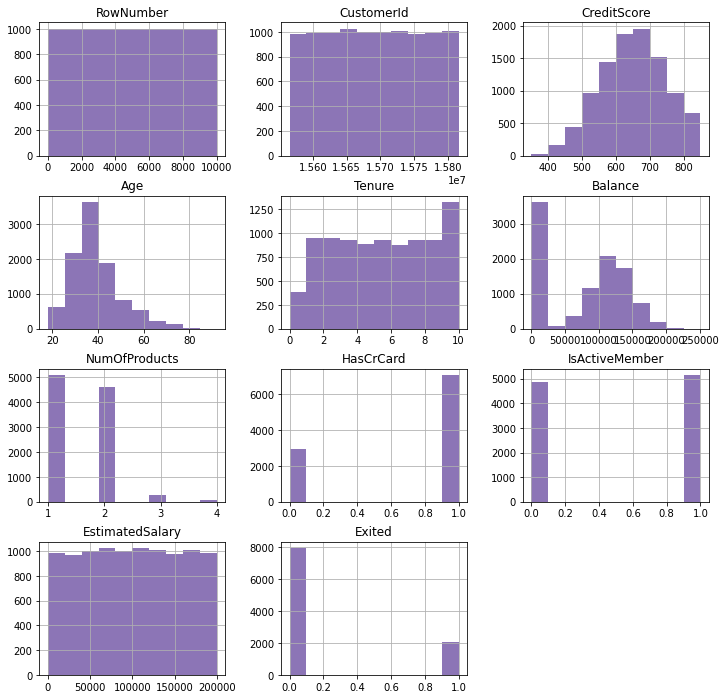

In [4]:
print('Распределение числовых столбцов датасета в виде гистрограмм')
data.hist(figsize=(12, 12), color = "#8c75b6", bins=10);

Уже здесь мы видим дисбаланс в классе, это говорит о том, что скорее всего придется с ним бороться для достижения максимального качества работы модели.

Также, в некоторых признаках (например кол-во продуктов, возможно возраст) наблюдаются сильно разнящиеся значения, предполагаю могут быть выборсы - проверим на этапе обработки.

### Общая обработка

**Избавимся от лишнего, проверим дубликаты и т.д.**

Как мы видим,
- `RowNumber` - номер строки, дублирует индекс;
- `CustomerId` - идентификатор пользователя, и `Surname` - фамилия, нам не нужно с этим связывать модель;

не являются для нас ценными данными, сразу избавимся от них.

In [5]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Приведем названия столбцов к snake_case:

In [6]:
data.columns = data.columns.str.lower()
data.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [7]:
data = data.rename(columns={
    'creditscore':'credit_score', 'numofproducts':'num_of_products', 'hascrcard':'has_cr_card', 
    'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'})
data.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [8]:
print('Посмотрим на дубликаты.\nКоличество явных дубликатов:', sum(data.duplicated()))

Посмотрим на дубликаты.
Количество явных дубликатов: 0


### Пропуски

**Посмотрим на пропущенные значения:**

In [9]:
pd.DataFrame({'Пропусков, шт.': data.isna().sum(), '% ': data.isna().sum()/data.shape[0]*100})

,"Пропусков, шт.",%
credit_score,0,0.0
geography,0,0.0
gender,0,0.0
age,0,0.0
tenure,909,9.09
balance,0,0.0
num_of_products,0,0.0
has_cr_card,0,0.0
is_active_member,0,0.0
estimated_salary,0,0.0


Пропуски наблюдаются только в столбце tenure (лет человек является клиентом).

In [10]:
data[data['tenure'].isna()]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.0,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.0,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.0,0


~~Видим разнообразные данные, ненулевые балансы, - т.е. неизвестно почему пропущено значение,<br/>
чтобы не терять данные и при этом не записывать тех, у кого не указано и тех, кто меньше года (ноль),<br/>
заменим в этих строках значение на -1.~~

1) Желательно не удалять эти строки, потому что это >9% данных!

2) Проставить в этих строках ноль мы тоже не можем, потому что у нас есть данные, где ноль. Т.е. мы можем только предположить, что незаполненные данные это тоже клиент моложе года, но не факт.

3) Поэтому, мы проставим в этих строках медиану.

In [11]:
# data.loc[data['tenure'].isna(),'tenure'] = -1

original_data = data.copy()
data.loc[data['tenure'].isna(), 'tenure'] = data.loc[~data['tenure'].isna(), 'tenure'].median()

In [12]:
pd.DataFrame({'Пропусков, шт.': data.isna().sum(), '% ': data.isna().sum()/data.shape[0]*100})

,"Пропусков, шт.",%
credit_score,0,0.0
geography,0,0.0
gender,0,0.0
age,0,0.0
tenure,0,0.0
balance,0,0.0
num_of_products,0,0.0
has_cr_card,0,0.0
is_active_member,0,0.0
estimated_salary,0,0.0


От пропусков избавились.

In [13]:
display(data.info()); print('На данном этапе данные обработаны.');
print(f'Осталось {(len(data)/len(original_data)*100)}% от оригинального датасета после обработки.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


None

На данном этапе данные обработаны.
Осталось 100.0% от оригинального датасета после обработки.


### Выбросы

**Посмотрим нет ли выбросов, которые теоретически могут нам помешать.**

In [14]:
# выше мы видим, что у нас из числовых только int64 и float64
numeric_columns = list(data.select_dtypes(include=['int64','float64']).columns.values)
numeric_columns.remove('exited')
print('Числовые признаки:',numeric_columns)

Числовые признаки: ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary']


credit_score


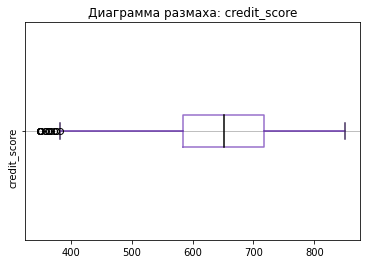

Минимальное значение: 350, Максимальное 850.
Межквартальный размах 134.0, левый ус до 383.0, правый до 850
Доля выбросов credit_score слева: < 383.0: 0.15 % (15)
Доля выбросов credit_score справа: > 850: 0.0 % (0)

---------

age


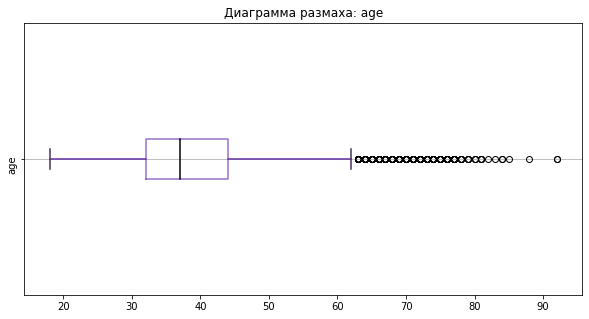

Минимальное значение: 18, Максимальное 92.
Межквартальный размах 12.0, левый ус до 18, правый до 62.0
Доля выбросов age слева: < 18: 0.0 % (0)
Доля выбросов age справа: > 62.0: 3.59 % (359)

---------

tenure


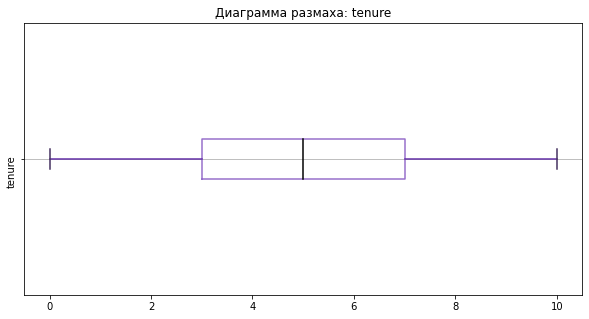

Минимальное значение: 0.0, Максимальное 10.0.
Межквартальный размах 4.0, левый ус до 0.0, правый до 10.0
Доля выбросов tenure слева: < 0.0: 0.0 % (0)
Доля выбросов tenure справа: > 10.0: 0.0 % (0)

---------

balance


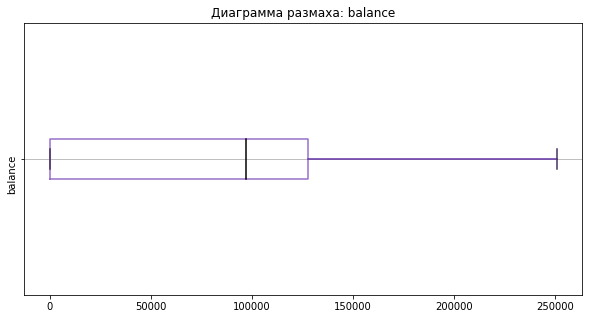

Минимальное значение: 0.0, Максимальное 250898.09.
Межквартальный размах 127644.24, левый ус до 0.0, правый до 250898.09
Доля выбросов balance слева: < 0.0: 0.0 % (0)
Доля выбросов balance справа: > 250898.09: 0.0 % (0)

---------

num_of_products


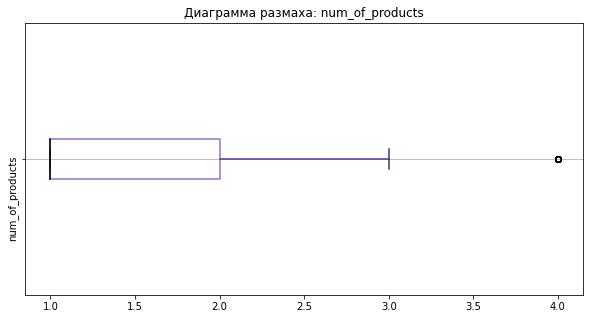

Минимальное значение: 1, Максимальное 4.
Межквартальный размах 1.0, левый ус до 1, правый до 3.5
Доля выбросов num_of_products слева: < 1: 0.0 % (0)
Доля выбросов num_of_products справа: > 3.5: 0.6 % (60)

---------

has_cr_card


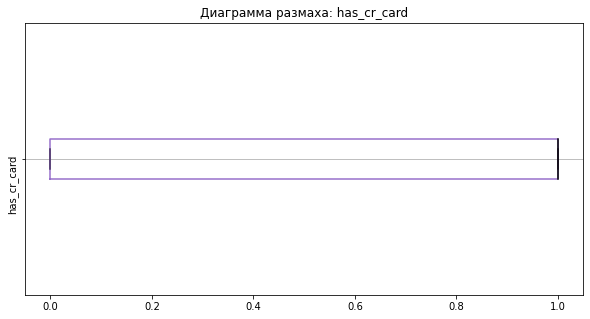

Минимальное значение: 0, Максимальное 1.
Межквартальный размах 1.0, левый ус до 0, правый до 1
Доля выбросов has_cr_card слева: < 0: 0.0 % (0)
Доля выбросов has_cr_card справа: > 1: 0.0 % (0)

---------

is_active_member


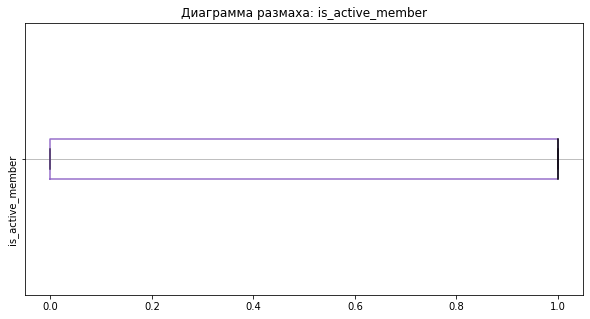

Минимальное значение: 0, Максимальное 1.
Межквартальный размах 1.0, левый ус до 0, правый до 1
Доля выбросов is_active_member слева: < 0: 0.0 % (0)
Доля выбросов is_active_member справа: > 1: 0.0 % (0)

---------

estimated_salary


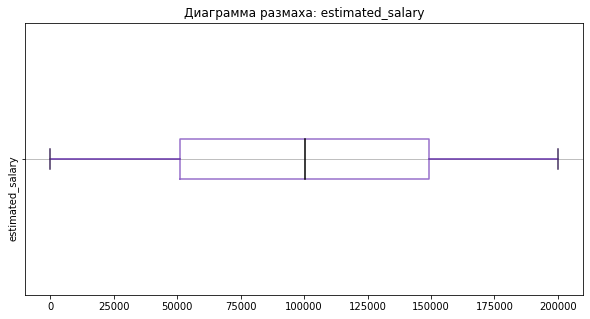

Минимальное значение: 11.58, Максимальное 199992.48.
Межквартальный размах 98386.14, левый ус до 11.58, правый до 199992.48
Доля выбросов estimated_salary слева: < 11.58: 0.0 % (0)
Доля выбросов estimated_salary справа: > 199992.48: 0.0 % (0)

---------

Осталось 100.0% от оригинального датасета после обработки.


In [15]:
# т.к. наши модели могут зависеть и от редких данных, в данном случае ставим порог 0.1%
porog = 0.001

for feature in numeric_columns:
    print(feature)
    fdata = data[feature]
    
    fig, ax2 = plt.subplots();
    pd.DataFrame({feature: fdata}).boxplot(
        boxprops={'linewidth':1.5,'color':'#976fcb'},
        flierprops={'linewidth':1.5,'color':'blue'},
        medianprops={'linewidth':1.5,'color':'#000000'},
        whiskerprops={'linewidth':1.5,'color':'#632fa7'},
        capprops={'linewidth':1.5,'color':'#432f5e'},
        column=[feature], figsize=(10,5), vert=False);
    ax2.grid(axis='x');
    plt.rcParams["figure.figsize"] = [10, 5];
    plt.title('Диаграмма размаха: '+feature);
    plt.yticks(rotation=90)
    plt.show();
    
    _min = fdata.min()
    _max = fdata.max()
    print(f'Минимальное значение: {_min}, Максимальное {_max}.')

    fdata_describe = fdata.describe()
    #display(fdata_describe);
    _razm = round(fdata_describe['75%']-fdata_describe['25%'],2)
    _left = round(fdata_describe['25%']-(_razm*1.5),2)
    _left = _left if _left>_min else _min
    _right = round(fdata_describe['75%']+(_razm*1.5),2);
    _right = _right if _right<_max else _max
    print(f'Межквартальный размах {_razm}, левый ус до {_left}, правый до {_right}')

    _vib_left = len(fdata[fdata<_left]) / fdata.count()
    print(f'Доля выбросов {feature} слева: < {_left}:', 
        round(_vib_left * 100, 2), f'% ({len(fdata[fdata<_left])})')
    if _vib_left and _vib_left<porog:
        data.drop(data.loc[data[feature]<_left].index, inplace=True)
        data = data.reset_index(drop=True); print('> > > УДАЛЕНО!')
    
    _vib_right = len(fdata[fdata>_right]) / fdata.count()
    print(f'Доля выбросов {feature} справа: > {_right}:', 
        round(_vib_right * 100, 2), f'% ({len(fdata[fdata>_right])})')
    if _vib_right and _vib_right<porog:
        print(_vib_right,porog)
        data.drop(data.loc[data[feature]>_right].index, inplace=True)
        data = data.reset_index(drop=True); print('> > > УДАЛЕНО!')
    
    print(); print('---------'); print(); 
    
print(f'Осталось {(len(data)/len(original_data)*100)}% от оригинального датасета после обработки.')

**На данном этапе предобработка завершена. Выводы:**
- Данные загружены и просмотрены, определены признаки и класс.
- Признаки `RowNumber`, `CustomerId` и `Surname` удалены, так как от них класс не может зависеть.
- Преобразованы названия столбцов, типы данных.
- Обработаны выбросы, отсутствующие значения.

## Исследование задачи

**Так как целевой признак (класс) у нас принимает всего два значения (либо ушел клиент, либо нет),<br/>то перед нами стоит задача классификации.**

Будем строить модели, предназначенные для классификации, а именно:<br/>`LogisticRegression`, `DecisionTreeClassifier` и `RandomForestClassifier`.

### Подготовка к обучению

#### Исследование признаков и класса

Посмотрим на наши данные:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


None

Распределение числовых столбцов датасета в виде гистрограмм


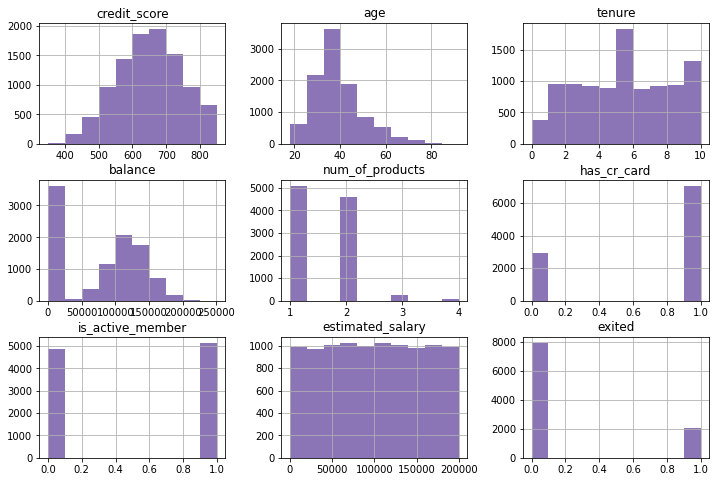

In [16]:
display(data.info())
print('Распределение числовых столбцов датасета в виде гистрограмм')
data.hist(figsize=(12, 8), color = "#8c75b6", bins=10);

Посмотрим на корреляцию признаков, и класса:

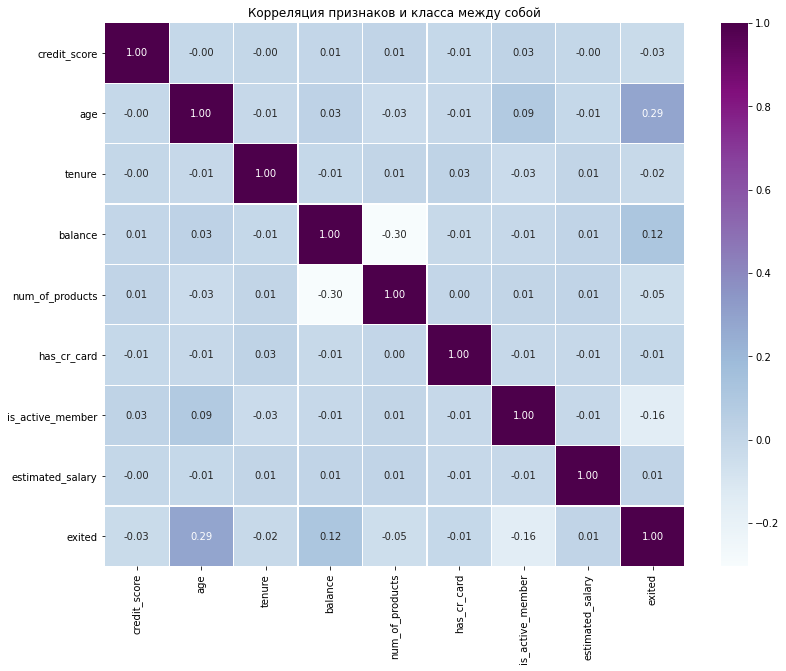

In [17]:
fig, ax = plt.subplots(figsize=(13,10))
sb.heatmap(data.corr(), cmap="BuPu", annot=True, fmt='.2f', linewidth=.1);
plt.title('Корреляция признаков и класса между собой')
plt.show();

**Сами признаки друг с другом не коррелируют в большинстве случаев, кроме (\~-0.3) кол-ва продуктов с балансом.<br/>Корреляция с классом (\~0.3) наблюдается только у фичи age, это скорее хорошо, чем плохо.**<br/>Пока ни с чем не боремся, попробуем обучить модели и посмотреть на их качество.

**Посмотрим подробнее на баланс класса:**

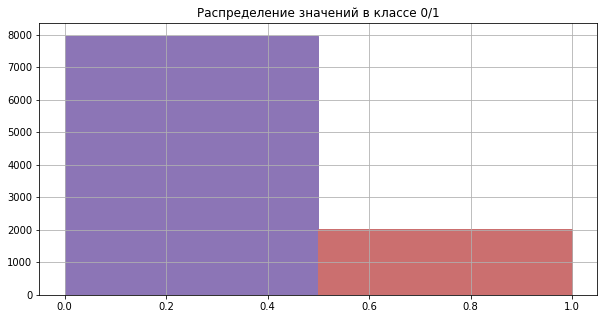

In [18]:
ax = data['exited'].hist(bins=2);
for i,rect in enumerate(ax.patches):
    color = '#8c75b6' if i==0 else '#cb6f6f' if i==1 else '#bdbdbd'
    rect.set_color(color)
plt.title('Распределение значений в классе 0/1')
plt.show();

In [19]:
data['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

**Наблюдаем явный дисбаланс в классе 0/1 в соотношении ~4:1, пока просто обратим на это внимание.**<br/>

In [20]:
original_data = data.copy()

#### Подготовка датасетов

In [21]:
# reset
data = original_data.copy()
# разобьем данные на признаки и целевое значение
features = data.drop(['exited'], axis=1)
target = data['exited']

# разделим данные на train, test
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=randomstate
)
# а теперь сделаем валидационную выборку
features_train, features_val, target_train, target_val = train_test_split(
    features_train, target_train, test_size=0.25, stratify=target_train, random_state=randomstate
)

numeric_features = list(features_train.select_dtypes(include=[np.number]).columns.values)
categorial_features = list(features_train.columns.difference(numeric_features))

print('Размеры выборок:')
print(f'Обучающая (train): {features_train.shape[0]} строк,',
      round(features_train.shape[0]/data.shape[0]*100,2),'%')
print(f'Валидационная (valid): {features_val.shape[0]} строк,',
      round(features_val.shape[0]/data.shape[0]*100,2),'%')
print(f'Тестовая (test):  {features_test.shape[0]} строк,',
      round(features_test.shape[0]/data.shape[0]*100,2),'%')

Размеры выборок:
Обучающая (train): 6000 строк, 60.0 %
Валидационная (valid): 2000 строк, 20.0 %
Тестовая (test):  2000 строк, 20.0 %


#### Кодировка категориальных признаков

Закодируем данные методом OHE

In [22]:
print('Категориальные признаки:',categorial_features)

Категориальные признаки: ['gender', 'geography']


In [23]:
# создаем encoder
train_ohe = OneHotEncoder(handle_unknown='ignore').fit(features_train[categorial_features])

In [24]:
# кодируем датасеты + удаляем "дублирующий" bool столбец Female (т.к. где Male 0 итак ясно что Female 1)
# тем самым не попадаем в ловушку

features_train = get_ohe_encoded_df(features_train,categorial_features,train_ohe)
features_train.drop(['Female'], axis=1, inplace=True)

features_val = get_ohe_encoded_df(features_val,categorial_features,train_ohe)
features_val.drop(['Female'], axis=1, inplace=True)

features_test = get_ohe_encoded_df(features_test,categorial_features,train_ohe)
features_test.drop(['Female'], axis=1, inplace=True)

In [25]:
display(features_train.head())
display(features_val.head())
display(features_test.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Male,France,Germany,Spain
0,698,37,2.0,166178.02,2,1,1,71972.95,0.0,1.0,0.0,0.0
1,576,36,8.0,166287.85,1,1,1,23305.85,0.0,0.0,1.0,0.0
2,703,42,5.0,63227.0,1,0,1,137316.32,1.0,0.0,1.0,0.0
3,773,39,4.0,0.0,2,0,1,182081.45,0.0,0.0,0.0,1.0
4,496,59,7.0,91680.1,2,1,0,163141.18,0.0,0.0,1.0,0.0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Male,France,Germany,Spain
0,646,33,2.0,0.0,2,0,0,198208.0,0.0,1.0,0.0,0.0
1,696,43,4.0,114091.38,1,0,1,159888.1,1.0,0.0,1.0,0.0
2,842,29,8.0,0.0,2,1,1,123437.05,1.0,1.0,0.0,0.0
3,538,68,9.0,0.0,2,1,0,110440.5,1.0,0.0,0.0,1.0
4,542,39,4.0,109949.39,2,1,1,41268.65,0.0,1.0,0.0,0.0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Male,France,Germany,Spain
0,628,45,5.0,0.0,2,1,1,96862.56,1.0,1.0,0.0,0.0
1,585,35,2.0,0.0,2,1,0,98621.04,0.0,1.0,0.0,0.0
2,797,24,5.0,0.0,2,1,0,182257.61,1.0,1.0,0.0,0.0
3,512,43,1.0,0.0,2,1,1,52471.36,1.0,1.0,0.0,0.0
4,576,41,4.0,112609.91,1,0,0,191035.18,0.0,1.0,0.0,0.0


**Вывод:** получили датасеты с закодированнымии методом OneHotEncoder категориальными признаками (geography, gender).

#### Масштабирование числовых признаков

Нам необходимо масштабировать числовые признаки, чтобы модели не считали один признак просто с большими значениями важнее другого, а делала это относительно.

In [26]:
print('Числовые признаки:\n',numeric_features)

Числовые признаки:
 ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary']


In [27]:
# создаем scaler
train_scaler = StandardScaler().fit(features_train[numeric_features])

In [28]:
# масштабируем
features_train[numeric_features] = train_scaler.transform(features_train[numeric_features])
features_val[numeric_features] = train_scaler.transform(features_val[numeric_features])
features_test[numeric_features] = train_scaler.transform(features_test[numeric_features])

In [29]:
display(features_train.head())
display(features_val.head())
display(features_test.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Male,France,Germany,Spain
0,0.48519602401403106,-0.18270697623705204,-1.0830569460978192,1.4307686586494375,0.8108331968912275,0.646091668153197,0.9956760150020264,-0.4971752005440733,0.0,1.0,0.0,0.0
1,-0.7746108339071126,-0.2798312658997005,1.0786135123776195,1.432520226723715,-0.914955799684638,0.646091668153197,0.9956760150020264,-1.3468614631273164,0.0,0.0,1.0,0.0
2,0.5368274526173566,0.3029144720761902,-0.0022217168600999117,-0.2110934905472482,-0.914955799684638,-1.5477679860172513,0.9956760150020264,0.6436645832090991,1.0,0.0,1.0,0.0
3,1.2596674530639145,0.011541603088244853,-0.36250012660600633,-1.219437245735481,0.8108331968912275,-1.5477679860172513,0.9956760150020264,1.4252257611661383,0.0,0.0,0.0,1.0
4,-1.6007136915603217,1.9540273963412138,0.718335102631713,0.2426763498808333,0.8108331968912275,0.646091668153197,-1.0043427630402093,1.0945447214366797,0.0,0.0,1.0,0.0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Male,France,Germany,Spain
0,-0.05177083346055476,-0.5712041348876458,-1.0830569460978192,-1.219437245735481,0.8108331968912275,-1.5477679860172513,-1.0043427630402093,1.7067816376794664,0.0,1.0,0.0,0.0
1,0.46454345257270085,0.4000387617388386,-0.36250012660600633,0.6000912870718267,-0.914955799684638,-1.5477679860172513,0.9956760150020264,1.037748705502213,1.0,0.0,1.0,0.0
2,1.9721811677898073,-0.9597012935382396,1.0786135123776195,-1.219437245735481,0.8108331968912275,0.646091668153197,0.9956760150020264,0.40134430824544337,1.0,1.0,0.0,0.0
3,-1.1670096912923869,2.82814600330505,1.438891922123526,-1.219437245735481,0.8108331968912275,0.646091668153197,-1.0043427630402093,0.17443557532369025,1.0,0.0,0.0,1.0
4,-1.1257045484097266,0.011541603088244853,-0.36250012660600633,0.5340348594293304,0.8108331968912275,0.646091668153197,0.9956760150020264,-1.0332462200261192,0.0,1.0,0.0,0.0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Male,France,Germany,Spain
0,-0.2376439764325268,0.5942873410641355,-0.0022217168600999117,-1.219437245735481,0.8108331968912275,0.646091668153197,0.9956760150020264,-0.06262373357656316,1.0,1.0,0.0,0.0
1,-0.6816742624211266,-0.37695555556234894,-1.0830569460978192,-1.219437245735481,0.8108331968912275,0.646091668153197,-1.0043427630402093,-0.03192216518585613,0.0,1.0,0.0,0.0
2,1.5074983103598771,-1.4453227418514818,-0.0022217168600999117,-1.219437245735481,0.8108331968912275,0.646091668153197,-1.0043427630402093,1.4283013652604164,1.0,1.0,0.0,0.0
3,-1.4354931200296799,0.4000387617388386,-1.4433353558437256,-1.219437245735481,0.8108331968912275,0.646091668153197,0.9956760150020264,-0.8376564110852962,1.0,1.0,0.0,0.0
4,-0.7746108339071126,0.20579018241354174,-0.36250012660600633,0.5764648138404743,-0.914955799684638,-1.5477679860172513,-1.0043427630402093,1.581550288000066,0.0,1.0,0.0,0.0


**Вывод:** получили датасеты с отмасштабированными StandardScaler числовыми признаками<br/>(credit_score, age, tenure, balance, num_of_products, has_cr_card, is_active_member, estimated_salary).

**Выводы:**
- Изучили баланс класса, данные 0/1 распределены в сооотношении **4:1**
- Категориальные признаки преобразовали (закодировали) методом OHE.
- Числовые признаки маштабировали при помощи StandardScaler.

Данные готовы для построения моделей.

### Обучение моделей

**Мы будем использовать основную метрику F1-мера (объединяет показания точности и полноты), т.к. она поставлена в задаче.**

Дополнительно мы будем считать показать AUC ROC (площадь под ROC-кривой), отражающий то, насколько наша модель лучше случайной.<br/>Чем больше значение AUC, тем «лучше» модель классификации.

In [30]:
all_results = {}

#### Модель LogisticRegression

In [31]:
## LogisticRegression
model_name = 'LogisticRegression'

# обозначим параметры для подбора
param_max_iter = list(range(2000,10001,2000))
param_max_iter.insert(0,100) #default
LogisticRegression_parametrs = {
    'max_iter' : param_max_iter,
    'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'saga']
}

In [32]:
'''
# создаем объект модели
model = LogisticRegression(random_state=randomstate)
# используем функцию с gridsearch
print('Starting GridSearchCV...'); start = time.time()   
result = fit_predict(model, features_train, target_train, features_val, target_val,
                     LogisticRegression_parametrs, verbose=10)
end = time.time()
print('GridSearchCV end. Время:',(end-start),'сек.')
''';

In [33]:
print(f'{model_name}...');  start = time.time()
result = do_LogisticRegression_fitpredict(LogisticRegression_parametrs,
                                          features_train,target_train,features_val,target_val)
end = time.time()
print('Время:',(end-start),'сек.')

# записываем результат
all_results[model_name] = result
print()

LogisticRegression...


  0%|          | 0/24 [00:00<?, ?it/s]

Время: 7.414806127548218 сек.



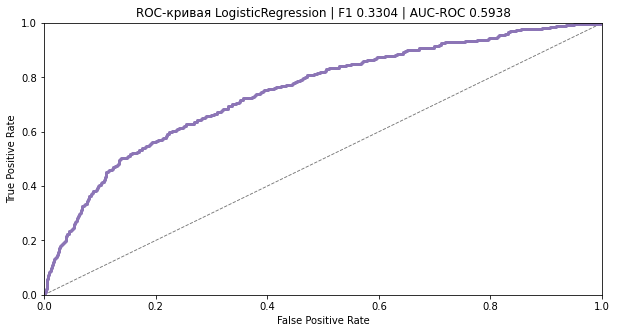


Лучшая модель LogisticRegression показала F1-меру 0.3304
Параметры: {'max_iter': 100, 'solver': 'liblinear'}


In [34]:
# выводим график 
do_roc_curve(target_val,all_results[model_name]['result']['probabilities'],
             model_name,result['result']['f1'],result['result']['auc_roc']);
print()
print(f"Лучшая модель {model_name} показала F1-меру {result['result']['f1']:.4f}")
print('Параметры:',result['params'])

#### Модель DecisionTreeClassifier

In [35]:
## DecisionTreeClassifier
model_name = 'DecisionTreeClassifier'

# обозначим параметры для подбора
param_max_depth = [i for i in range(1,10)]
param_max_depth.append(None)
DecisionTreeClassifier_parametrs = {
    'max_depth' : param_max_depth,
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'min_samples_leaf' : [i for i in range(2,6)]
}

In [36]:
'''
# создаем объект модели
model = DecisionTreeClassifier(random_state=randomstate)
# используем функцию с gridsearch
print('Starting GridSearchCV...'); start = time.time()   
result = fit_predict(model, features_train, target_train, features_val, target_val,
                     DecisionTreeClassifier_parametrs, verbose=10)
end = time.time()
print('GridSearchCV end. Время:',(end-start),'сек.')
''';

In [37]:
print(f'{model_name}...');  start = time.time()
result = do_DecisionTreeClassifier_fitpredict(DecisionTreeClassifier_parametrs,
                                          features_train,target_train,features_val,target_val)
end = time.time()
print('Время:',(end-start),'сек.')

# записываем результат
all_results[model_name] = result
print()

DecisionTreeClassifier...


  0%|          | 0/160 [00:00<?, ?it/s]

Время: 2.1559035778045654 сек.



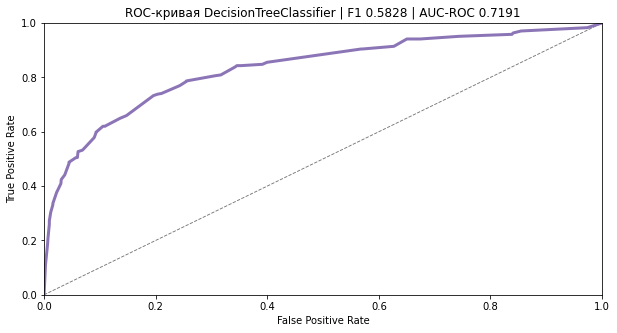


Лучшая модель DecisionTreeClassifier показала F1-меру 0.5828
Параметры: {'max_depth': 7, 'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 4}


In [38]:
# выводим график 
do_roc_curve(target_val,all_results[model_name]['result']['probabilities'],
             model_name,result['result']['f1'],result['result']['auc_roc']);
print()
print(f"Лучшая модель {model_name} показала F1-меру {result['result']['f1']:.4f}")
print('Параметры:',result['params'])

#### Модель RandomForestClassifier

In [39]:
## RandomForestClassifier
model_name = 'RandomForestClassifier'

# обозначим параметры для подбора
param_max_depth = [i for i in range(1,5)]
param_max_depth.append(None)
RandomForestClassifier_parametrs = {
    'min_samples_split' : [2,4],
    'n_estimators' : [100, 200, 300],
    'criterion' : ['gini', 'entropy']
}

In [40]:
'''
# создаем объект модели
model = RandomForestClassifier(random_state=randomstate)
# используем функцию с gridsearch
print('Starting GridSearchCV...'); start = time.time()   
result = fit_predict(model, features_train, target_train, features_val, target_val,
                     RandomForestClassifier_parametrs, verbose=10)
end = time.time()
print('GridSearchCV end. Время:',(end-start),'сек.')
''';

In [41]:
print(f'{model_name}...');  start = time.time()
result = do_RandomForestClassifier_fitpredict(RandomForestClassifier_parametrs,
                                          features_train,target_train,features_val,target_val)
end = time.time()
print('Время:',(end-start),'сек.')

# записываем результат
all_results[model_name] = result
print()

RandomForestClassifier...


  0%|          | 0/12 [00:00<?, ?it/s]

Время: 16.68181324005127 сек.



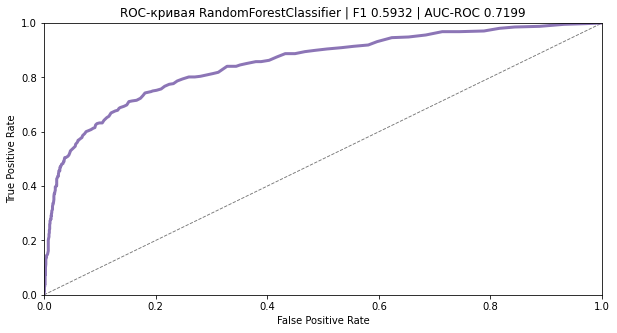


Лучшая модель RandomForestClassifier показала F1-меру 0.5932
Параметры: {'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 2}


In [42]:
# выводим график 
do_roc_curve(target_val,all_results[model_name]['result']['probabilities'],
             model_name,result['result']['f1'],result['result']['auc_roc']);
print()
print(f"Лучшая модель {model_name} показала F1-меру {result['result']['f1']:.4f}")
print('Параметры:',result['params'])

#### Выводы

In [43]:
df_data = []
for model, model_result in all_results.items():
    df_data.append([
        model,
        str(round(model_result['result']['f1'],4)),
        str(round(model_result['result']['auc_roc'],4)),
        str(round(model_result['result']['precision'],4)),
        str(round(model_result['result']['recall'],4)),
        str(model_result['params'])
    ])
df = pd.DataFrame(df_data, columns=['Модель', 'F1', 'AUC-ROC', 'Precision', 'Recall', 'Параметры'])
df = df.sort_values('F1',ascending=False)

**Посмотрим, какие модели нам удалось построить.**

In [44]:
df.style.hide_index()

Модель,F1,AUC-ROC,Precision,Recall,Параметры
RandomForestClassifier,0.5932,0.7199,0.8093,0.4681,"{'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 2}"
DecisionTreeClassifier,0.5828,0.7191,0.7351,0.4828,"{'max_depth': 7, 'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 4}"
LogisticRegression,0.3304,0.5938,0.5689,0.2328,"{'max_iter': 100, 'solver': 'liblinear'}"


In [45]:
print(f"Лучше всего показала себя модель {df.iloc[0]['Модель']}")

Лучше всего показала себя модель RandomForestClassifier


**Вывод:** нам удалось достичь 0.59 требуемой F1-меры на валидационной выборке, однако скорее всего на тестовой она провалится.

## Борьба с дисбалансом

In [46]:
features_train_original = features_train.copy()
target_train_original = target_train.copy()

### Анализ класса

**Как мы помним, по всем данным у нас был дисбаланс в соотношении 4:1.<br/>Посмотрим на распределение значений в классе в обучающей выборке:**

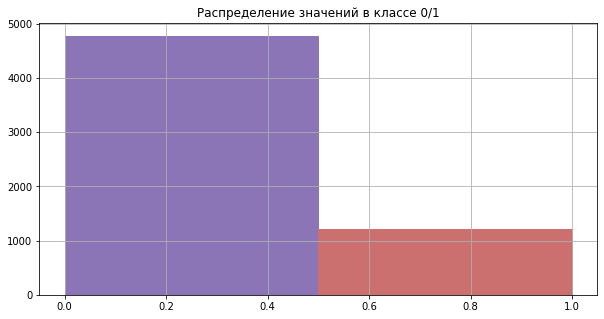

In [47]:
ax = target_train.hist(bins=2);
for i,rect in enumerate(ax.patches):
    color = '#8c75b6' if i==0 else '#cb6f6f' if i==1 else '#bdbdbd'
    rect.set_color(color)
plt.title('Распределение значений в классе 0/1')
plt.show();

In [48]:
_all = target_train.shape[0]; _v0 = target_train.value_counts()[0]; _v1 = target_train.value_counts()[1]
print('Всего строк:',_all); print('Строк класс = 0:',_v0); print('Строк класс = 1:',_v1)
print('Соотношение',round(_v0/_all*10),':',round(_v1/_all*10))

Всего строк: 6000
Строк класс = 0: 4778
Строк класс = 1: 1222
Соотношение 8 : 2


**Наблюдаем явный и большой дисбаланс в классе.**

Мы можем использовать три подхода для "борьбы" с дисбалансом:<br/>
уменьшить выборку, увеличить выборку, использовать взвешенные классы.

### Upsampling 

**Попробуем избавиться от дисбаланса путем увеличения выборки.**

Для того, чтобы сбалансировать обучающую выборку используем upsampling, т.е. увеличение редких значений класса.<br/>Увеличим количество строк, где класс = 1 (редкий), чтобы их количества стали равны, и обязательно сделаем shuffle.

*Нам необходимо произвести два тестирования:<br/>1) во сколько раз увеличиваем класс 1;<br/>
2) сами параметры модели.*

**При upsampling (т.е. размножении) у нас появляются строки-дубликаты. Поэтому использовать гридсерч с кроссвалидацией не представляется возможным, будем использовать циклы с перебором параметров.**

#### Обучение, оценка моделей

In [49]:
# reset на случай если что-то пойдет не так
features_train = features_train_original.copy()
target_train = target_train_original.copy()
# выводим инфу
_all = target_train.shape[0]; _v0 = target_train.value_counts()[0]; _v1 = target_train.value_counts()[1]
need_upsample = round(round(_v0/_all*10) / round(_v1/_all*10))
upsample_increases = list(range(2,need_upsample+1))
print(f'Максимальное увеличение класса в {need_upsample} раз(а).')
print('Множители upsample для перебора:',upsample_increases)

Максимальное увеличение класса в 4 раз(а).
Множители upsample для перебора: [2, 3, 4]


In [50]:
upsampled_results = {}

for upsample_increase in upsample_increases:
    upsampled_results[upsample_increase] = {}
    print('-'*40)
    
    # сбрасываем датасеты
    features_train = features_train_original.copy()
    target_train = target_train_original.copy()
    
        
    # увеличиваем выборку через функцию
    features_train, target_train = upsample(features_train, target_train, 1, upsample_increase)
    print(f"UPSAMPLE: x{upsample_increase} ({target_train.value_counts()[0]}:{target_train.value_counts()[1]})")
    print()
    
    # строим модели
    
    ## LogisticRegression
    model_name = 'LogisticRegression'
    print(f'{model_name}...')
    result = do_LogisticRegression_fitpredict(LogisticRegression_parametrs,
                                              features_train,target_train,features_val,target_val)
    print(f"Лучшая модель {model_name} показала F1-меру {result['result']['f1']:.4f}")
    print('Параметры:',result['params'])    
    upsampled_results[upsample_increase][model_name] = result
    print()
    
    ## DecisionTreeClassifier
    model_name = 'DecisionTreeClassifier'
    print(f'{model_name}...')
    result = do_DecisionTreeClassifier_fitpredict(DecisionTreeClassifier_parametrs,
                                              features_train,target_train,features_val,target_val)
    print(f"Лучшая модель {model_name} показала F1-меру {result['result']['f1']:.4f}")
    print('Параметры:',result['params'])    
    upsampled_results[upsample_increase][model_name] = result
    print()
    
    ## RandomForestClassifier
    model_name = 'RandomForestClassifier'
    print(f'{model_name}...')
    result = do_RandomForestClassifier_fitpredict(RandomForestClassifier_parametrs,
                                              features_train,target_train,features_val,target_val)
    print(f"Лучшая модель {model_name} показала F1-меру {result['result']['f1']:.4f}")
    print('Параметры:',result['params'])    
    upsampled_results[upsample_increase][model_name] = result
    
    print()
    print()

print('Готово!')

----------------------------------------
UPSAMPLE: x2 (4778:2444)

LogisticRegression...


  0%|          | 0/24 [00:00<?, ?it/s]

Лучшая модель LogisticRegression показала F1-меру 0.4655
Параметры: {'max_iter': 100, 'solver': 'liblinear'}

DecisionTreeClassifier...


  0%|          | 0/160 [00:00<?, ?it/s]

Лучшая модель DecisionTreeClassifier показала F1-меру 0.6104
Параметры: {'max_depth': 8, 'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 5}

RandomForestClassifier...


  0%|          | 0/12 [00:00<?, ?it/s]

Лучшая модель RandomForestClassifier показала F1-меру 0.6270
Параметры: {'criterion': 'gini', 'n_estimators': 100, 'min_samples_split': 2}


----------------------------------------
UPSAMPLE: x3 (4778:3666)

LogisticRegression...


  0%|          | 0/24 [00:00<?, ?it/s]

Лучшая модель LogisticRegression показала F1-меру 0.4948
Параметры: {'max_iter': 100, 'solver': 'liblinear'}

DecisionTreeClassifier...


  0%|          | 0/160 [00:00<?, ?it/s]

Лучшая модель DecisionTreeClassifier показала F1-меру 0.6170
Параметры: {'max_depth': 7, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 3}

RandomForestClassifier...


  0%|          | 0/12 [00:00<?, ?it/s]

Лучшая модель RandomForestClassifier показала F1-меру 0.6293
Параметры: {'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 4}


----------------------------------------
UPSAMPLE: x4 (4778:4888)

LogisticRegression...


  0%|          | 0/24 [00:00<?, ?it/s]

Лучшая модель LogisticRegression показала F1-меру 0.4767
Параметры: {'max_iter': 100, 'solver': 'liblinear'}

DecisionTreeClassifier...


  0%|          | 0/160 [00:00<?, ?it/s]

Лучшая модель DecisionTreeClassifier показала F1-меру 0.5959
Параметры: {'max_depth': 7, 'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 2}

RandomForestClassifier...


  0%|          | 0/12 [00:00<?, ?it/s]

Лучшая модель RandomForestClassifier показала F1-меру 0.6280
Параметры: {'criterion': 'entropy', 'n_estimators': 300, 'min_samples_split': 4}


Готово!


#### Выводы

**Посмотрим на результаты метода upsampling**



Посмотрим на предыдущие результаты, а именно
Таблица по моделям несбалансированной выборки:


Модель,F1,AUC-ROC,Precision,Recall,Параметры
RandomForestClassifier,0.5932,0.7199,0.8093,0.4681,"{'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 2}"
DecisionTreeClassifier,0.5828,0.7191,0.7351,0.4828,"{'max_depth': 7, 'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 4}"
LogisticRegression,0.3304,0.5938,0.5689,0.2328,"{'max_iter': 100, 'solver': 'liblinear'}"



********************************************************************************

И сравним с новыми,
РЕЗУЛЬТАТЫ МЕТОДА UPSAMPLING (лучшие модели)


Upsample xN,Модель,F1,AUC-ROC,Precision,Recall,Параметры
3,RandomForestClassifier,0.629300,0.7527,0.7121,0.5637,"{'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 4}"
4,RandomForestClassifier,0.628000,0.7538,0.6976,0.5711,"{'criterion': 'entropy', 'n_estimators': 300, 'min_samples_split': 4}"
2,RandomForestClassifier,0.627000,0.747,0.7441,0.5417,"{'criterion': 'gini', 'n_estimators': 100, 'min_samples_split': 2}"
3,DecisionTreeClassifier,0.617000,0.7643,0.5959,0.6397,"{'max_depth': 7, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 3}"
2,DecisionTreeClassifier,0.610400,0.7537,0.6181,0.6029,"{'max_depth': 8, 'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 5}"
4,DecisionTreeClassifier,0.595900,0.7684,0.5142,0.7083,"{'max_depth': 7, 'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 2}"
3,LogisticRegression,0.494800,0.6924,0.4296,0.5833,"{'max_iter': 100, 'solver': 'liblinear'}"
4,LogisticRegression,0.476700,0.6872,0.3757,0.652,"{'max_iter': 100, 'solver': 'liblinear'}"
2,LogisticRegression,0.465500,0.6622,0.4958,0.4387,"{'max_iter': 100, 'solver': 'liblinear'}"


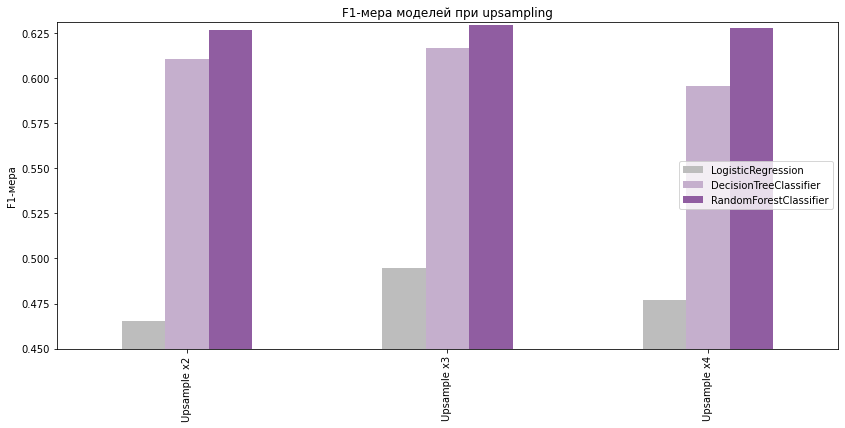

Как мы видим, увеличив выборку для борьбы с дилбалансом, мы улучшили качество моделей.
Решающих задачу (f1 >0.59) моделей: 6
Лучшая модель: RandomForestClassifier, при увеличении класса 1: 3.00
F1: 0.6293, AUC-ROC: 0.7527


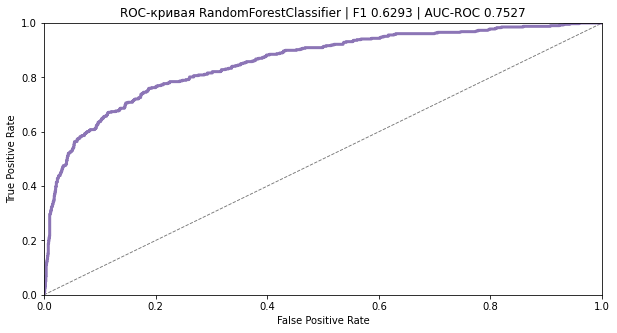

In [51]:
df_data2 = []
df_chart_data = []
upsample_best = {}; upsample_best_f1 = 0;
for upsample_increase, models_results in upsampled_results.items():     
    for model, model_result in models_results.items():
        if model_result['result']['f1']>upsample_best_f1:
            upsample_best_f1 = model_result['result']['f1']
            upsample_best = {'factor':upsample_increase,'type':model,'result':model_result}
        df_chart_data.append(['Upsample x'+str(upsample_increase), model, model_result['result']['f1']])
        df_data2.append([
            upsample_increase,
            model,
            str(round(model_result['result']['f1'],4)),
            str(round(model_result['result']['auc_roc'],4)),
            str(round(model_result['result']['precision'],4)),
            str(round(model_result['result']['recall'],4)),
            str(model_result['params'])
        ])
        
print()
print()
print('Посмотрим на предыдущие результаты, а именно\nТаблица по моделям несбалансированной выборки:')
display(df.style.hide_index())
print()
print('*'*80)
print()
print('И сравним с новыми,')
print('РЕЗУЛЬТАТЫ МЕТОДА UPSAMPLING (лучшие модели)')

# делаем датафрейм таблицы
df2 = pd.DataFrame(df_data2, columns=['Upsample xN', 'Модель', 'F1', 'AUC-ROC', 'Precision', 'Recall', 'Параметры'])
df2['F1'] = df2['F1'].astype('float64')
df2 = df2.sort_values('F1',ascending=False)

# выводим новую таблицу
display(df2.style.hide_index())

# рисуем график
df_chart = pd.DataFrame(df_chart_data, columns=['Upsample xN','Модель','F1-мера'])
ax = df_chart.pivot('Upsample xN','Модель','F1-мера').reindex(
    ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier'], axis=1).plot.bar(
    color=['#bdbdbd','#c5afcd','#905da1'],
    figsize=(14,6), ylim=(.45,.631)
)
ax.legend(loc='center right')
ax.set_title('F1-мера моделей при upsampling')
ax.set_ylabel('F1-мера')
ax.set_xlabel('')
plt.show();

# выводим инфу
print(f'Как мы видим, увеличив выборку для борьбы с дилбалансом, мы улучшили качество моделей.')
print("Решающих задачу (f1 >0.59) моделей:", len(df2[df2['F1']>.59]))
print(f"Лучшая модель: {df2.iloc[0]['Модель']}, при увеличении класса 1: {df2.iloc[0]['Upsample xN']:.2f}")
print(f"F1: {df2.iloc[0]['F1']}, AUC-ROC: {df2.iloc[0]['AUC-ROC']}")

upsample_best_model_results = upsampled_results[df2.iloc[0]['Upsample xN']][df2.iloc[0]['Модель']]

# посмотрим на графике
do_roc_curve(target_val,upsample_best_model_results['result']['probabilities'],
             model_name,upsample_best_model_results['result']['f1'],
             upsample_best_model_results['result']['auc_roc']);

### Downsampling 

**Попробуем избавиться от дисбаланса путем уменьшения выборки.**

Для того, чтобы сбалансировать обучающую выборку используем downsampling, т.е. уменьшим кол-во частых значений класса.
Уменьшим количество строк, где класс = 0 (частый), чтобы их количества стали равны, и обязательно сделаем shuffle.

*Нам необходимо произвести два тестирования:<br/>1) во сколько раз уменьшаем класс 0;<br/>
2) сами параметры модели.*

*При downsampling (т.е. режем данные) у нас не появляются строки-дубликаты. Поэтому можно было бы использовать гридсерч с кроссвалидацией, но будем использовать циклы с перебором параметров для наглядности.*

#### Обучение, оценка моделей

In [52]:
# reset на случай если что-то пойдет не так
features_train = features_train_original.copy()
target_train = target_train_original.copy()
# выводим инфу
_all = target_train.shape[0]; _v0 = target_train.value_counts()[0]; _v1 = target_train.value_counts()[1]
need_downsample = round(round(_v0/_all*10) / round(_v1/_all*10))
need_downsample_frac = 1/need_downsample
downsample_fracs = list(np.arange(need_downsample_frac,.76,.25))
print(f'Максимальное уменьшение класса 0 в {need_downsample} раз(а).')
print('Множители downsample для перебора:',downsample_fracs)

Максимальное уменьшение класса 0 в 4 раз(а).
Множители downsample для перебора: [0.25, 0.5, 0.75]


In [53]:
downsampled_results = {}

for downsample_frac in downsample_fracs:
    downsampled_results[downsample_frac] = {}
    print('-'*40)
    
    # сбрасываем датасеты
    features_train = features_train_original.copy()
    target_train = target_train_original.copy()
    
    # увеличиваем выборку через функцию
    # уменьшаем выборку через функцию
    features_train, target_train = downsample(features_train, target_train, 1, downsample_frac)
    print(f"DOWNSAMPLE: {downsample_frac} ({target_train.value_counts()[0]}:{target_train.value_counts()[1]})")
    print()
    
    # строим модели
    
    ## LogisticRegression
    model_name = 'LogisticRegression'
    print(f'{model_name}...')
    result = do_LogisticRegression_fitpredict(LogisticRegression_parametrs,
                                              features_train,target_train,features_val,target_val)
    print(f"Лучшая модель {model_name} показала F1-меру {result['result']['f1']:.4f}")
    print('Параметры:',result['params'])    
    downsampled_results[downsample_frac][model_name] = result
    print()
    
    ## DecisionTreeClassifier
    model_name = 'DecisionTreeClassifier'
    print(f'{model_name}...')
    result = do_DecisionTreeClassifier_fitpredict(DecisionTreeClassifier_parametrs,
                                              features_train,target_train,features_val,target_val)
    print(f"Лучшая модель {model_name} показала F1-меру {result['result']['f1']:.4f}")
    print('Параметры:',result['params'])    
    downsampled_results[downsample_frac][model_name] = result
    print()
    
    ## RandomForestClassifier
    model_name = 'RandomForestClassifier'
    print(f'{model_name}...')
    result = do_RandomForestClassifier_fitpredict(RandomForestClassifier_parametrs,
                                              features_train,target_train,features_val,target_val)
    print(f"Лучшая модель {model_name} показала F1-меру {result['result']['f1']:.4f}")
    print('Параметры:',result['params'])    
    downsampled_results[downsample_frac][model_name] = result
    
    print()
    print()

print('Готово!')

----------------------------------------
DOWNSAMPLE: 0.25 (1194:1222)

LogisticRegression...


  0%|          | 0/24 [00:00<?, ?it/s]

Лучшая модель LogisticRegression показала F1-меру 0.4818
Параметры: {'max_iter': 100, 'solver': 'liblinear'}

DecisionTreeClassifier...


  0%|          | 0/160 [00:00<?, ?it/s]

Лучшая модель DecisionTreeClassifier показала F1-меру 0.6070
Параметры: {'max_depth': 5, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 3}

RandomForestClassifier...


  0%|          | 0/12 [00:00<?, ?it/s]

Лучшая модель RandomForestClassifier показала F1-меру 0.5979
Параметры: {'criterion': 'gini', 'n_estimators': 200, 'min_samples_split': 4}


----------------------------------------
DOWNSAMPLE: 0.5 (2389:1222)

LogisticRegression...


  0%|          | 0/24 [00:00<?, ?it/s]

Лучшая модель LogisticRegression показала F1-меру 0.4709
Параметры: {'max_iter': 100, 'solver': 'liblinear'}

DecisionTreeClassifier...


  0%|          | 0/160 [00:00<?, ?it/s]

Лучшая модель DecisionTreeClassifier показала F1-меру 0.6085
Параметры: {'max_depth': 8, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 5}

RandomForestClassifier...


  0%|          | 0/12 [00:00<?, ?it/s]

Лучшая модель RandomForestClassifier показала F1-меру 0.6285
Параметры: {'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 2}


----------------------------------------
DOWNSAMPLE: 0.75 (3584:1222)

LogisticRegression...


  0%|          | 0/24 [00:00<?, ?it/s]

Лучшая модель LogisticRegression показала F1-меру 0.3855
Параметры: {'max_iter': 100, 'solver': 'liblinear'}

DecisionTreeClassifier...


  0%|          | 0/160 [00:00<?, ?it/s]

Лучшая модель DecisionTreeClassifier показала F1-меру 0.6044
Параметры: {'max_depth': 8, 'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 3}

RandomForestClassifier...


  0%|          | 0/12 [00:00<?, ?it/s]

Лучшая модель RandomForestClassifier показала F1-меру 0.6254
Параметры: {'criterion': 'gini', 'n_estimators': 200, 'min_samples_split': 2}


Готово!


#### Выводы

**Посмотрим на результаты метода downsampling**



Посмотрим на предыдущие результаты, а именно
Таблица по моделям несбалансированной выборки:


Модель,F1,AUC-ROC,Precision,Recall,Параметры
RandomForestClassifier,0.5932,0.7199,0.8093,0.4681,"{'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 2}"
DecisionTreeClassifier,0.5828,0.7191,0.7351,0.4828,"{'max_depth': 7, 'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 4}"
LogisticRegression,0.3304,0.5938,0.5689,0.2328,"{'max_iter': 100, 'solver': 'liblinear'}"



********************************************************************************

И сравним с новыми,
РЕЗУЛЬТАТЫ МЕТОДА DOWNSAMPLING (лучшие модели)


Downsample xN,Модель,F1,AUC-ROC,Precision,Recall,Параметры
0.500000,RandomForestClassifier,0.628500,0.7616,0.6534,0.6054,"{'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 2}"
0.750000,RandomForestClassifier,0.625400,0.7443,0.7587,0.5319,"{'criterion': 'gini', 'n_estimators': 200, 'min_samples_split': 2}"
0.500000,DecisionTreeClassifier,0.608500,0.759,0.5864,0.6324,"{'max_depth': 8, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 5}"
0.250000,DecisionTreeClassifier,0.607000,0.7634,0.5642,0.6569,"{'max_depth': 5, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 3}"
0.750000,DecisionTreeClassifier,0.604400,0.7382,0.6875,0.5392,"{'max_depth': 8, 'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 3}"
0.250000,RandomForestClassifier,0.597900,0.7812,0.4898,0.7672,"{'criterion': 'gini', 'n_estimators': 200, 'min_samples_split': 4}"
0.250000,LogisticRegression,0.481800,0.692,0.378,0.6642,"{'max_iter': 100, 'solver': 'liblinear'}"
0.500000,LogisticRegression,0.470900,0.6656,0.4986,0.4461,"{'max_iter': 100, 'solver': 'liblinear'}"
0.750000,LogisticRegression,0.385500,0.6172,0.5422,0.299,"{'max_iter': 100, 'solver': 'liblinear'}"


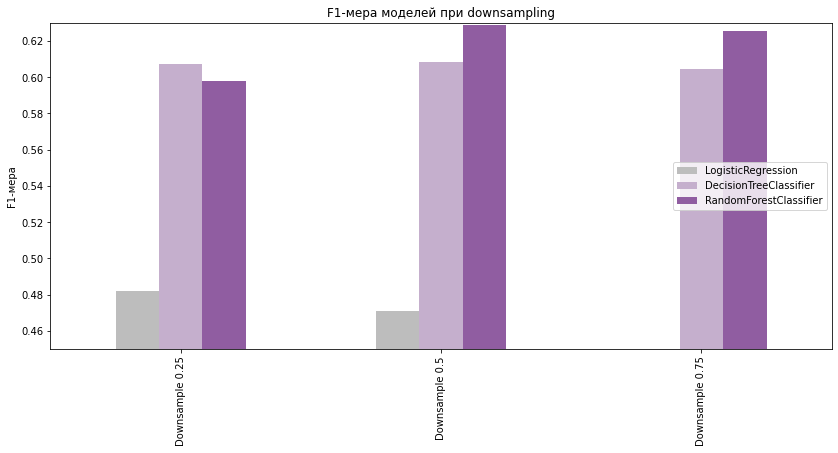

Как мы видим, уменьшив выборку для борьбы с дилбалансом, мы улучшили качество моделей.
Решающих задачу (f1 >0.59) моделей: 6
Лучшая модель: RandomForestClassifier, при уменьшении класса 0: 0.50
F1: 0.6285, AUC-ROC: 0.7616


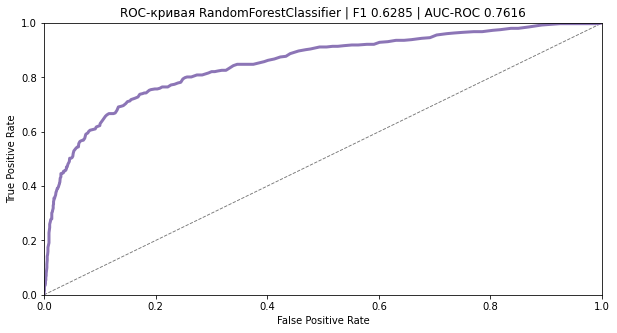

In [54]:
df_data3 = []
df_chart_data2 = []
downsample_best = {}; downsample_best_f1 = 0;
for downsample_frac, models_results in downsampled_results.items():
    for model, model_result in models_results.items():
        if model_result['result']['f1']>downsample_best_f1:
            downsample_best_f1 = model_result['result']['f1']
            downsample_best = {'factor':downsample_frac,'type':model,'result':model_result}
        df_chart_data2.append(['Downsample '+str(downsample_frac), model, model_result['result']['f1']])
        df_data3.append([
            downsample_frac,
            model,
            str(round(model_result['result']['f1'],4)),
            str(round(model_result['result']['auc_roc'],4)),
            str(round(model_result['result']['precision'],4)),
            str(round(model_result['result']['recall'],4)),
            str(model_result['params'])
        ])
        
print()
print()
print('Посмотрим на предыдущие результаты, а именно\nТаблица по моделям несбалансированной выборки:')
display(df.style.hide_index())
print()
print('*'*80)
print()
print('И сравним с новыми,')
print('РЕЗУЛЬТАТЫ МЕТОДА DOWNSAMPLING (лучшие модели)')

# делаем датафрейм таблицы
df3 = pd.DataFrame(df_data3, columns=['Downsample xN', 'Модель', 'F1', 'AUC-ROC', 'Precision', 'Recall', 'Параметры'])
df3['F1'] = df3['F1'].astype('float64')
df3 = df3.sort_values('F1',ascending=False)

# выводим новую таблицу
display(df3.style.hide_index())

# рисуем график
df_chart2 = pd.DataFrame(df_chart_data2, columns=['Downsample xN','Модель','F1-мера'])
ax = df_chart2.pivot('Downsample xN','Модель','F1-мера').reindex(
    ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier'], axis=1).plot.bar(
    color=['#bdbdbd','#c5afcd','#905da1'],
    figsize=(14,6), ylim=(.45,.63)
)
ax.legend(loc='center right')
ax.set_title('F1-мера моделей при downsampling')
ax.set_ylabel('F1-мера')
ax.set_xlabel('')
plt.show();

# выводим инфу
print(f'Как мы видим, уменьшив выборку для борьбы с дилбалансом, мы улучшили качество моделей.')
print("Решающих задачу (f1 >0.59) моделей:", len(df3[df3['F1']>.59]))
print(f"Лучшая модель: {df3.iloc[0]['Модель']}, при уменьшении класса 0: {df3.iloc[0]['Downsample xN']:.2f}")
print(f"F1: {df3.iloc[0]['F1']}, AUC-ROC: {df3.iloc[0]['AUC-ROC']}")

downsample_best_model_results = downsampled_results[df3.iloc[0]['Downsample xN']][df3.iloc[0]['Модель']]

# посмотрим на графике
do_roc_curve(target_val,downsample_best_model_results['result']['probabilities'],
             model_name,downsample_best_model_results['result']['f1'],
             downsample_best_model_results['result']['auc_roc']);

### Взвешивание классов 

**Попробуем избавиться от дисбаланса путем взвешивания классов.**

Для того, чтобы сбалансировать обучающую выборку используем взвешивание классов, т.е. модели будут учитывать "вес" класса в засимости от того, как часто он встречается.<br/><br/>Для этого будем использовать параметр `class_weight='balanced'`.

In [55]:
# reset на случай если что-то пойдет не так
features_train = features_train_original.copy()
target_train = target_train_original.copy()

In [56]:
_all = target_train.shape[0]; _v0 = target_train.value_counts()[0]; _v1 = target_train.value_counts()[1]
print('Всего строк:',_all); print('Строк класс = 0:',_v0); print('Строк класс = 1:',_v1)
print('Соотношение',round(_v0/_all*10),':',round(_v1/_all*10))

Всего строк: 6000
Строк класс = 0: 4778
Строк класс = 1: 1222
Соотношение 8 : 2


In [57]:
weight_balanced_results = {}
df_chart_balanced_data = []

#### Модель LogisticRegression

In [58]:
## LogisticRegression
model_name = 'LogisticRegression'

In [59]:
'''
# создаем объект модели
model = LogisticRegression(class_weight='balanced', random_state=randomstate)
# используем функцию с gridsearch
print('Starting GridSearchCV...'); start = time.time()   
result = fit_predict(model, features_train, target_train, features_val, target_val,
                     LogisticRegression_parametrs, verbose=10)
end = time.time()
print('GridSearchCV end. Время:',(end-start),'сек.')
''';

In [60]:
print(f'{model_name}...');  start = time.time()
result = do_LogisticRegression_fitpredict(
    LogisticRegression_parametrs,
    features_train, target_train,features_val, target_val, class_weight='balanced')
end = time.time()
print('Время:',(end-start),'сек.')

# записываем результат
weight_balanced_results[model_name] = result
print()

LogisticRegression...


  0%|          | 0/24 [00:00<?, ?it/s]

Время: 6.504877090454102 сек.



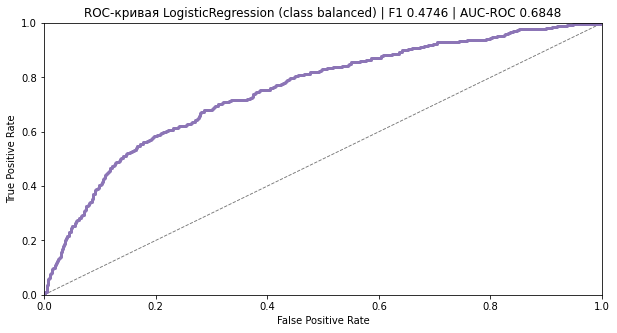


Лучшая модель LogisticRegression class_weight='balanced' показала F1-меру 0.4746
Параметры: {'max_iter': 100, 'solver': 'liblinear'}


In [61]:
# выводим график 
do_roc_curve(target_val,weight_balanced_results[model_name]['result']['probabilities'],
             model_name+' (class balanced)',result['result']['f1'],result['result']['auc_roc']);
print()
print(f"Лучшая модель {model_name} class_weight='balanced' показала F1-меру {result['result']['f1']:.4f}")
print('Параметры:',result['params'])

#### Модель DecisionTreeClassifier

In [62]:
## DecisionTreeClassifier
model_name = 'DecisionTreeClassifier'

In [63]:
'''
# создаем объект модели
model = DecisionTreeClassifier(class_weight='balanced', random_state=randomstate)

# используем функцию с gridsearch
print('Starting GridSearchCV...'); start = time.time()   
result = fit_predict(model, features_train, target_train, features_val, target_val,
                     DecisionTreeClassifier_parametrs, verbose=10)
end = time.time()
print('GridSearchCV end. Время:',(end-start),'сек.')
''';

In [64]:
print(f'{model_name}...');  start = time.time()
result = do_DecisionTreeClassifier_fitpredict(
    DecisionTreeClassifier_parametrs,
    features_train, target_train,features_val, target_val, class_weight='balanced')
end = time.time()
print('Время:',(end-start),'сек.')

# записываем результат
weight_balanced_results[model_name] = result
print()

DecisionTreeClassifier...


  0%|          | 0/160 [00:00<?, ?it/s]

Время: 2.330782890319824 сек.



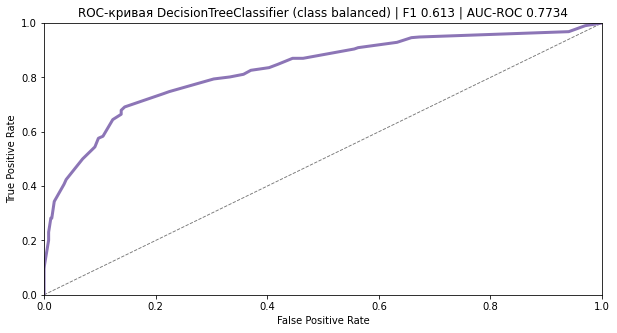


Лучшая модель DecisionTreeClassifier class_weight='balanced' показала F1-меру 0.6130
Параметры: {'max_depth': 6, 'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 3}


In [65]:
# выводим график 
do_roc_curve(target_val,weight_balanced_results[model_name]['result']['probabilities'],
             model_name+' (class balanced)',result['result']['f1'],result['result']['auc_roc']);
print()
print(f"Лучшая модель {model_name} class_weight='balanced' показала F1-меру {result['result']['f1']:.4f}")
print('Параметры:',result['params'])

#### Модель RandomForestClassifier

In [66]:
## RandomForestClassifier
model_name = 'RandomForestClassifier'

In [67]:
'''
# создаем объект модели
model = RandomForestClassifier(class_weight='balanced', random_state=randomstate)
# используем функцию с gridsearch
print('Starting GridSearchCV...'); start = time.time()   
result = fit_predict(model, features_train, target_train, features_val, target_val,
                     RandomForestClassifier_parametrs, verbose=10)
end = time.time()
print('GridSearchCV end. Время:',(end-start),'сек.')
''';

In [68]:
print(f'{model_name}...');  start = time.time()
result = do_RandomForestClassifier_fitpredict(
    RandomForestClassifier_parametrs,
    features_train, target_train,features_val, target_val, class_weight='balanced')
end = time.time()
print('Время:',(end-start),'сек.')

# записываем результат
weight_balanced_results[model_name] = result
print()

RandomForestClassifier...


  0%|          | 0/12 [00:00<?, ?it/s]

Время: 16.422913074493408 сек.



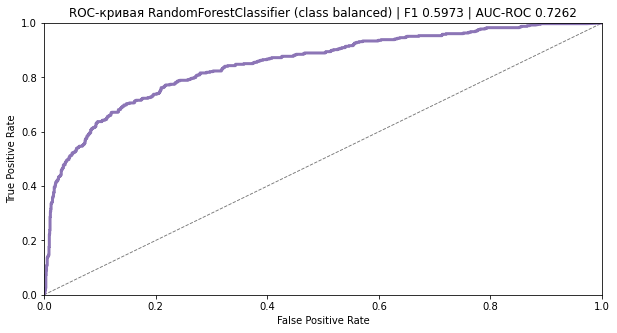


Лучшая модель RandomForestClassifier class_weight='balanced' показала F1-меру 0.5973
Параметры: {'criterion': 'gini', 'n_estimators': 100, 'min_samples_split': 4}


In [69]:
# выводим график 
do_roc_curve(target_val,weight_balanced_results[model_name]['result']['probabilities'],
             model_name+' (class balanced)',result['result']['f1'],result['result']['auc_roc']);
print()
print(f"Лучшая модель {model_name} class_weight='balanced' показала F1-меру {result['result']['f1']:.4f}")
print('Параметры:',result['params'])

#### Выводы

In [70]:
df_balanced_data = []
for model, model_result in weight_balanced_results.items():
    df_balanced_data.append([
        model,
        str(round(model_result['result']['f1'],4)),
        str(round(model_result['result']['auc_roc'],4)),
        str(round(model_result['result']['precision'],4)),
        str(round(model_result['result']['recall'],4)),
        str(model_result['params'])
    ])
df_balanced = pd.DataFrame(df_balanced_data,
                           columns=['Модель', 'F1', 'AUC-ROC', 'Precision', 'Recall', 'Параметры'])
df_balanced = df_balanced.sort_values('F1',ascending=False)

**Посмотрим, какие модели нам удалось построить.**

In [71]:
df_balanced.style.hide_index()

Модель,F1,AUC-ROC,Precision,Recall,Параметры
DecisionTreeClassifier,0.613,0.7734,0.5508,0.6912,"{'max_depth': 6, 'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 3}"
RandomForestClassifier,0.5973,0.7262,0.7585,0.4926,"{'criterion': 'gini', 'n_estimators': 100, 'min_samples_split': 4}"
LogisticRegression,0.4746,0.6848,0.3764,0.6422,"{'max_iter': 100, 'solver': 'liblinear'}"


**Сравним с моделями, построенными без учета веса класса:**

In [72]:
print('Сравнение моделей до и после применения взвешенного класса')
df_balanced.sort_index(inplace=True)
df.sort_index(inplace=True)
df_compare = df.compare(df_balanced)
df_compare = df_compare[['F1','AUC-ROC']]
df_compare.insert(loc=0, column='Модель', value=df_balanced['Модель'])
df_compare = df_compare.rename(columns={'self': 'было', 'other': 'стало'}, level=-1)
df_compare = df_compare.sort_values(('F1','стало'),ascending=False)
df_compare.style.hide_index()

Сравнение моделей до и после применения взвешенного класса


**Вывод:** лучше всего показала себя модель DecisionTreeClassifier,<br/>F1-мера по сравнению с несбалансированной выборкой увеличилась, требуемой F1-меры 0.59 удалось достичь.

### Общий вывод дисбаланс

**Мы проверили три подхода борьбы с дисбалансом:**

- увеличение выборки
- уменьшение выборки
- взвешивание классов

Лучшие модели каждого из трех подходов показывают результаты F1 лучше, чем несбалансированная выборка.

**✅ При использовании подхода взвешивание классов F1 лучшей модели превысил требуемый 0.59.**

In [73]:
display(df_compare[:1].style.hide_index()); print(); print()

**✅ При использовании подхода увеличение выборки (upsampling) задача решена:**<br/>

In [74]:
print(f"Лучшая модель: {upsample_best['type']}, при увеличении класса 1 в {upsample_best['factor']} раз(а)")
print(f"Показала F1: {upsample_best['result']['result']['f1']:.4f}, \
и AUC-ROC: {upsample_best['result']['result']['auc_roc']:.4f}")

Лучшая модель: RandomForestClassifier, при увеличении класса 1 в 3 раз(а)
Показала F1: 0.6293, и AUC-ROC: 0.7527


In [75]:
display(df2[:1].style.hide_index()); print(); print()

Upsample xN,Модель,F1,AUC-ROC,Precision,Recall,Параметры
3,RandomForestClassifier,0.629300,0.7527,0.7121,0.5637,"{'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 4}"


**✅ При использовании подхода уменьшение выборки (downsampling):**<br/>

In [76]:
print(f"Лучшая модель: {downsample_best['type']}, при уменьшении класса 0 * {downsample_best['factor']}")
print(f"Показала F1: {downsample_best['result']['result']['f1']:.4f}, \
и AUC-ROC: {downsample_best['result']['result']['auc_roc']:.4f}")

Лучшая модель: RandomForestClassifier, при уменьшении класса 0 * 0.5
Показала F1: 0.6285, и AUC-ROC: 0.7616


In [77]:
display(df3[:1].style.hide_index()); print(); print()

Downsample xN,Модель,F1,AUC-ROC,Precision,Recall,Параметры
0.500000,RandomForestClassifier,0.628500,0.7616,0.6534,0.6054,"{'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 2}"


**ВЫВОД: Удалось построить модель, которая соответствует поставленной задаче.<br/>Обозначим лучшей моделью модель с наибольшей F1-мерой на валидационной выборке.**

In [78]:
if downsample_best['result']['result']['f1']>upsample_best['result']['result']['f1']:
    best = downsample_best; best['approach'] = 'Downsample'
else:
    best = upsample_best; best['approach'] = 'Upsample'
print(f"Лучшая модель: {best['type']} подхода {best['approach']}")

Лучшая модель: RandomForestClassifier подхода Upsample


## Тестирование модели

### Лучшая модель

**Итак, у нас есть лучшая модель, а именно:**

Классификатор: RandomForestClassifier
Параметры датасета:
- Upsample выборки * 3
Параметры построения:
{'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 4}



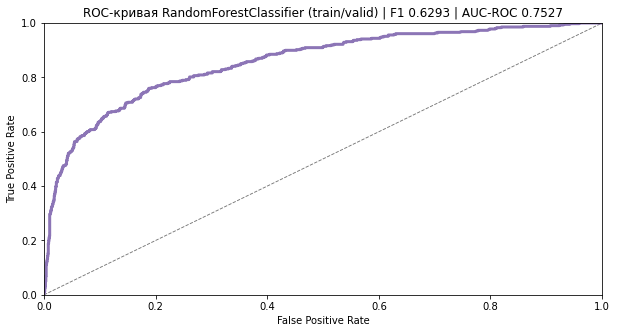

Показала на валидационной выборке:
F1: 0.6293
AUC-ROC: 0.7527
Precision: 0.7121
Recall: 0.5637



In [79]:
# объект модели
best_model = best['result']['model']
best_model_params = best['result']['params']

print(f"Классификатор: {best['type']}")
print(f"Параметры датасета:\n- {best['approach']} выборки * {best['factor']}")
print(f"Параметры построения:\n{best['result']['params']}")
print()
do_roc_curve(target_val,best['result']['result']['probabilities'],
             model_name+' (train/valid)',best['result']['result']['f1'],
             best['result']['result']['auc_roc']);
print(f"Показала на валидационной выборке:\nF1: {best['result']['result']['f1']:.4f}\n\
AUC-ROC: {best['result']['result']['auc_roc']:.4f}\n\
Precision: {best['result']['result']['precision']:.4f}\n\
Recall: {best['result']['result']['recall']:.4f}")
print()

### Проверка на тестовой выборке

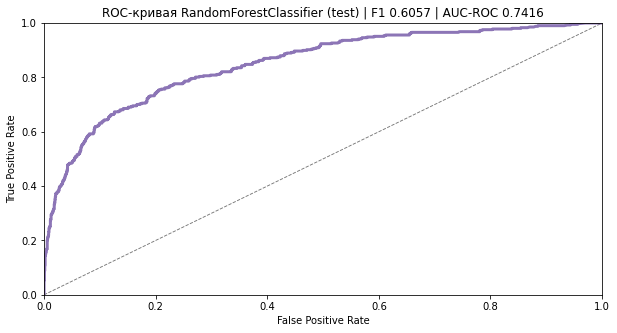

На тестовой выборке:
F1: 0.6057
AUC-ROC: 0.7416
Precision: 0.6696
Recall: 0.5528


In [80]:
# делаем классификацию
test_predictions = best_model.predict(features_test)

# считаем показатели
test_f1 = f1_score(target_test, test_predictions) 
test_precision = precision_score(target_test, test_predictions) 
test_recall = recall_score(target_test, test_predictions) 
test_auc_roc = roc_auc_score(target_test, test_predictions)
test_result = {
    'params': best_model_params,
    'result':{
        'precision':test_precision,
        'recall':test_recall,
        'f1':test_f1,
        'auc_roc':test_auc_roc,
        'predicted':test_predictions
    }
}

test_probabilities = best_model.predict_proba(features_test)
do_roc_curve(target_test, test_probabilities[:,1],
             model_name+' (test)', test_f1, test_auc_roc);
print(f"На тестовой выборке:\nF1: {test_f1:.4f}\n\
AUC-ROC: {test_auc_roc:.4f}\n\
Precision: {test_precision:.4f}\n\
Recall: {test_recall:.4f}")

**😎 Модель показала результат с F-мерой >0.59 на тестовой выборке. Задача решена.**

### Проверка на адекватность

Сравним нашу модель с работой DummyClassifier. Чтобы было честно, возьмем те же данные для обучения, что были и у нашей модели.

In [81]:
# создаём
model_dummy = DummyClassifier(strategy='constant', constant=1, random_state=randomstate) 
# учим
model_dummy.fit(best['result']['features_train'], best['result']['target_train']);

# делаем прогноз
dummy_pred_train = model_dummy.predict(best['result']['features_train'])
dummy_pred_val = model_dummy.predict(features_val)
dummy_pred_test = model_dummy.predict(features_test)

# считаем метрики

print('Модель DummyClassifier:')
dummy_f1_train = f1_score(best['result']['target_train'], dummy_pred_train) 
print(f'Train F1: {dummy_f1_train:.4f}.')

dummy_f1_val = f1_score(target_val, dummy_pred_val) 
print(f'Valid F1: {dummy_f1_val:.4f}.')

dummy_f1_test = f1_score(target_test, dummy_pred_test) 
print(f'Test F1: {dummy_f1_test:.4f}.')

dummy_accuracy_test = accuracy_score(target_test, dummy_pred_test) 
best_model_accuracy_test = accuracy_score(target_test, test_predictions) 
    
print()
if test_f1<=dummy_f1_test:
    print('Упс..')
else:
    print(f'Как мы видим, фиктивный классификатор показал результат F1: {dummy_f1_test:.4f}.')
    print(f'А наша модель имеет F1: {test_f1:.4f} на тестовой выборке!\n')
    print(f'При этом, accuracy_score dummy: {dummy_accuracy_test:.4f},')
    print(f'а у нашей модели {best_model_accuracy_test:.4f}, что тоже стоит отметить.\n')
    print('Соответственно, она не бесполезная.')
    

Модель DummyClassifier:
Train F1: 0.6055.
Valid F1: 0.3389.
Test F1: 0.3382.

Как мы видим, фиктивный классификатор показал результат F1: 0.3382.
А наша модель имеет F1: 0.6057 на тестовой выборке!

При этом, accuracy_score dummy: 0.2035,
а у нашей модели 0.8535, что тоже стоит отметить.

Соответственно, она не бесполезная.


## Общий вывод

**Была поставлена задача построить модель, предсказывающую уйдет ли клиент из банка, с показателем F1-меры не менее 0.59.**

1. Мы изучили цели и задачи проекта.
- Проблема: Из «Бета-Банка» стали уходить клиенты.
- Задача: Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.<br/>**Построить модель, предсказывающую уйдет ли клиент из банка, с показателем F1-меры не менее 0.59 на тестовое выборке.**

2. Загрузили, изучили и обработали данные.
- Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
- Мы изучили значения данных, их распределение, выбросы.
- Избавились от пропусков, преобразовали типы данных.

3. Мы исследовали поставленную задачу.
- Изучили корреляцию признаков, класса; Обратили внимание на дилбаланс в классе
- Подготовили данные к обучению моделей
- - Преобразовали категориальные признаки методом OHE
- - Масштабировали числовые признаки
- - Разбили данные на три выборки: обучающую, валидационную и тестовую
- Мы построили три модели (`LogisticRegression`, `DecisionTreeClassifier` и `RandomForestClassifier`) перебирая гиперпараметры для наилучшего результата.
- - Лучший результат F1-меры показала модель RandomForestClassifier, немного превысив требуемую F1-меру 0.59

4. Мы приняли решение улучшить модели учитывая дисбаланс в классе
- Применили метод увеличения выборки (`Upsampling`)
- - **Результат:** Лучшая модель RandomForestClassifier, при увеличении класса 1: 3.00,<br/>**F1: 0.6293**, AUC-ROC: 0.7527
- Применили метод уменьшения выборки (`Downsampling`)
- - **Результат:** Лучшая модель: RandomForestClassifier, при уменьшении класса 0: 0.75,<br/>**F1: 0.6285**, AUC-ROC: 0.7616
- Применили метод взвешивания классов (`class_weight='balanced'`)
- - **Результат:** Лучшая модель: RandomForestClassifier, F1: 0.613
- **Было принято решение выбрать лучшей моделью модель `Upsampling` х3 (F1: 0.6293 on valid)**
- - Модель RandomForestClassifier, при Upsample выборки * 3 меньшего класса,<br/>{'criterion': 'entropy', 'n_estimators': 200, 'min_samples_split': 4}

5. Мы протестировали лучшую модель на тестовой выборке
- Провели финальное тестирование и получили<br/>**Результат: F1: 0.61**, что соответствует поставленной задаче<br/>AUC-ROC: 0.7416, Precision: 0.6696, Recall: 0.5528
- Дополнительно мы успешно проверили выбранную модель на адекватность.

**Вывод: Мы построили модель, предсказывающую уйдет ли клиент из банка, с показателем F1-меры не менее 0.59.**